In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# Data Manipulation
import pandas as pd
pd.options.display.max_columns = 25
import numpy as np
from IPython.display import display
import missingno as msno

# Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid", {"axes.grid": False})
#import missingno as msno

# Machine Learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, log_loss
#from xgboost import XGBClassifier

In [4]:
SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [ ]:
#This project processes synthetic-aperture radar images and uses machine learning to identify whether each image contains a ship or an iceberg.
#Synthetic aperture radar (SAR) images are captured from a moving antenna emitting successive pulses of radio waves. Institutions mount these antenna on unmanned aerial reconnaissance vessels to surveil land areas.
#The images in this case study were collected from the Sentinel-1 satelite constillation, orbitting 600 kilometers above the earth. The Sentinel-1 is a side looking radar (SLAR), which means that the radar points in a direction perpendicular to the direction of flight 
#The Sentinel-1 transmits and receives energy in two channels: a vertical channel and a horizontal channel. These separate channels will help when analyzing the images because different objects have different polarimetric scattering features. We will explore a variety of transformation techniques to better understand how ships and icebergs reflect light and use these insights to distinguish our images.
# The purpose is to do some analysis and find out which features will be most helpful for doing classification.

In [1]:

import codecs
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
#test = pd.read_json('data/test.json')
#test_df = pd.DataFrame(test)
#train = pd.read_json(codecs.open('data/processed/train.json','r','utf-8'))
train = pd.read_json('data/processed/train.json')
train = pd.DataFrame(train)
train.info()
display(train.head())
train.describe()
display(train.inc_angle.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1604 entries, 0 to 1603
Data columns (total 5 columns):
band_1        1604 non-null object
band_2        1604 non-null object
id            1604 non-null object
inc_angle     1604 non-null object
is_iceberg    1604 non-null int64
dtypes: int64(1), object(4)
memory usage: 62.7+ KB


,band_1,band_2,id,inc_angle,is_iceberg
0,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",dfd5f913,43.9239,0
1,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",e25388fd,38.1562,0
2,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",58b2aaa0,45.2859,1
3,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",4cfc3a18,43.8306,0
4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",271f93f4,35.6256,0


count     1604
unique     879
top         na
freq       133
Name: inc_angle, dtype: object

In [ ]:
# As you see there are 133 missing values in inc_angle

count    1471.000000
mean       39.268707
std         3.839744
min        24.754600
25%        36.106100
50%        39.501500
75%        42.559100
max        45.937500
Name: inc_angle, dtype: float64

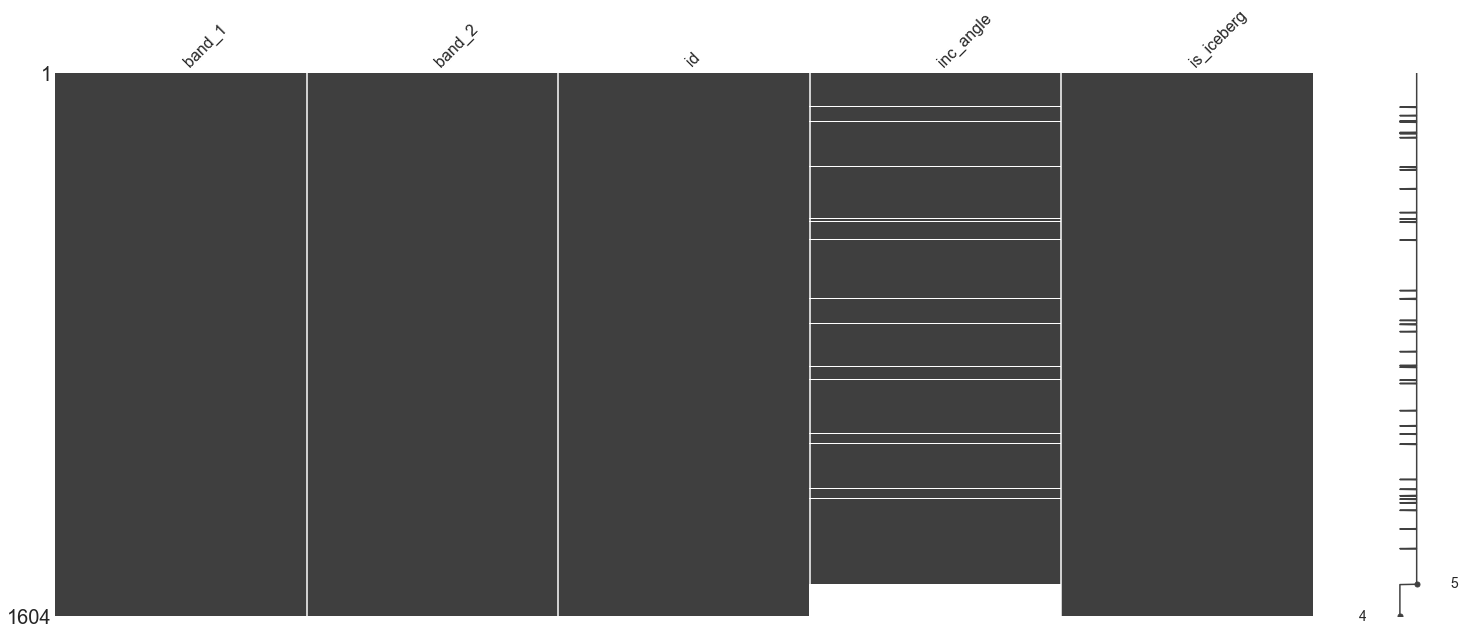

In [5]:
# Looking at Missing values 
train.replace('na', np.NaN, inplace=True)
train['inc_angle'] = pd.to_numeric(train['inc_angle'])

# 133 values missing from inc_angle
msno.matrix(train)
train.inc_angle.describe()

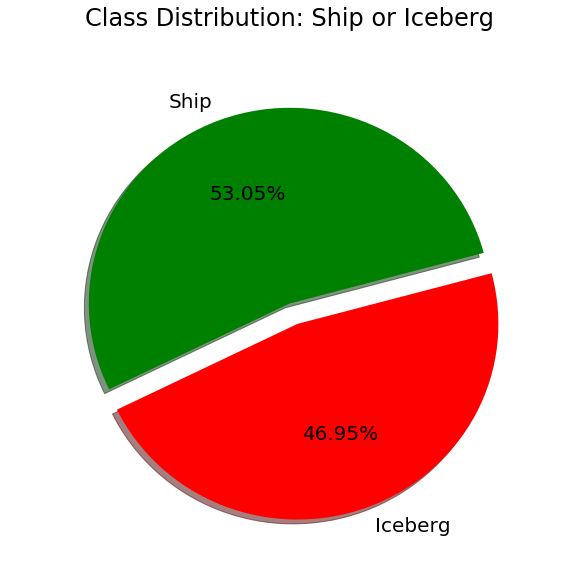

In [14]:
# Before modeling or engineering new features, let's visualize the data to gain a new perspective. 
# We can see from the plot below that there are more ships than icebergs in our dataset.
import pylab as plb
count_iceberg = train.is_iceberg.value_counts()
plt.figure(figsize=(10,10))
b= plb.round_(count_iceberg.values)
c=['green','red']
e=[0,0.1]
l = 'Ship','Iceberg'
plb.pie(b, explode= e, labels=l, colors=c, radius=.9, autopct='%1.2f%%', shadow=True, startangle=15)
#plt.xticks(range(2), ['Ships', 'Icebergs'])
plt.title('Class Distribution: Ship or Iceberg')
plt.show()


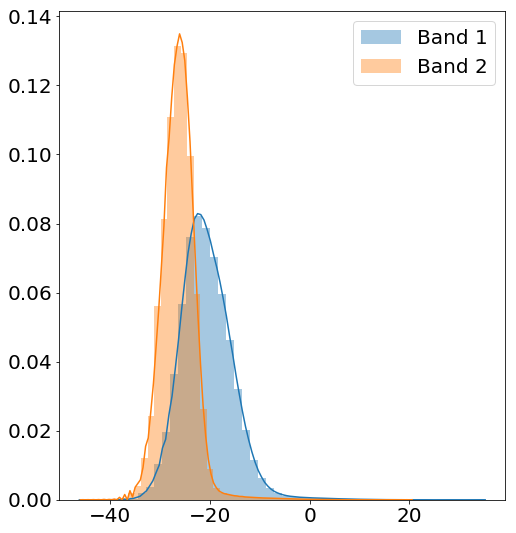

In [20]:
# Density Distribution using Backscattering 
# Backscatter (or backscattering) is the reflection of waves, particles, or signals back to the direction from which they came. 
#It is a diffuse reflection due to scattering, as opposed to specular reflection as from a mirror.

#angle_count  = train.inc_angle.value_counts()
plt.figure(figsize=(8,9))
tBand1 = []
tBand2 = []
for imgvec in train['band_1']:
    for db in imgvec:
        tBand1.append(db)
for imgvec in train['band_2']:
    for db in imgvec:
        tBand2.append(db)
sns.distplot(tBand1, label='Band 1')
sns.distplot(tBand2, label='Band 2')
plt.legend()
plt.show()

In [17]:
def clean_df(df):
    df['inc_angle'] = df['inc_angle'].replace("na", np.nan, inplace=False).astype(float)
    mean_inc_angle = df['inc_angle'].dropna(inplace=False).mean()
    df['inc_angle'] = df['inc_angle'].fillna(mean_inc_angle)
    df['band_1'] = df['band_1'].astype(list)
    df['band_2'] = df['band_2'].astype(list)
    return df
train_df = clean_df(train)

traindf = train_df.sample(16)
traindf
len(traindf)

,band_1,band_2,id,inc_angle,is_iceberg
1273,"[-14.574298, -16.255018, -14.104769, -14.41505...","[-22.178524, -21.263418, -20.435612, -23.20171...",251cbbb3,41.839300,0
423,"[-24.952816, -21.854843, -19.576046, -21.02712...","[-22.579021, -23.164875, -25.204735, -26.58641...",65460dbe,35.669800,0
136,"[-20.781023, -15.70899, -16.680073, -19.658928...","[-24.453911, -25.679379, -27.106571, -25.16844...",9bccbe2e,33.923500,0
1425,"[-21.642382, -21.145975, -22.538759, -25.16440...","[-23.538109, -26.850691, -27.835117, -26.25155...",c2b2df38,36.628600,0
27,"[-31.042643, -31.60326, -32.202568, -30.51619,...","[-34.297188, -32.846218, -30.019676, -29.10457...",70830858,43.789500,0
559,"[-17.448059, -16.379244, -15.51, -16.849007, -...","[-25.563366, -26.391293, -27.306511, -29.48947...",cbd26eff,34.859800,0
1094,"[-20.25029, -24.786032, -23.626251, -24.541401...","[-30.092258, -33.388523, -30.562002, -29.64685...",0b1d356b,37.704300,1
255,"[-23.769873, -24.961643, -23.335602, -20.62757...","[-27.632362, -28.742769, -31.508881, -26.64817...",72c46573,38.459100,1
1416,"[-12.504648, -13.031306, -17.210836, -12.22557...","[-24.377184, -23.329504, -21.391382, -24.37742...",d7f54a66,32.801000,1
1269,"[-19.751814, -20.278482, -15.814494, -13.73148...","[-25.772415, -28.797855, -26.859743, -25.27620...",b05baa18,31.413800,0


16

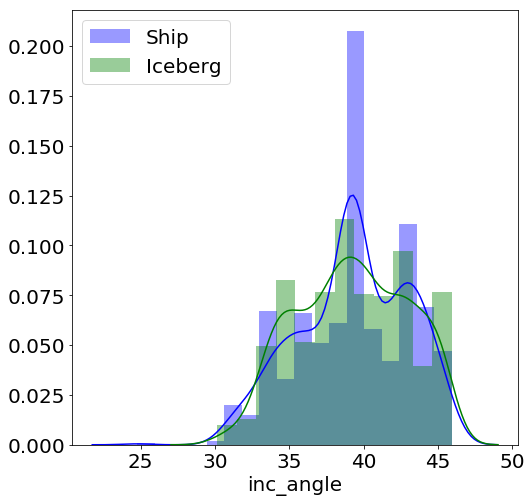

In [15]:
angle_count  = train.inc_angle.value_counts()
plt.figure(figsize=(8,8))
sns.distplot(train[train.is_iceberg==0].inc_angle.dropna(),color='b', label='Ship')
sns.distplot(train[train.is_iceberg==1].inc_angle.dropna(), color='g', label='Iceberg')
plt.legend()
plt.show()

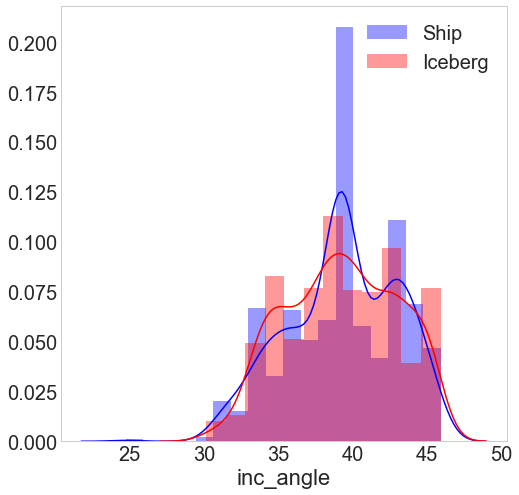

In [18]:

angle_count  = train_df.inc_angle.value_counts()
plt.figure(figsize=(8,8))
sns.distplot(
    train_df[train_df.is_iceberg==0].inc_angle,
    color='b', label='Ship'
)
sns.distplot(
    train_df[train_df.is_iceberg==1].inc_angle, color='r', label='Iceberg'
)
plt.legend()
plt.show()
#plt.hist(train.loc[traindf.is_iceberg==1,name],range=[minval,maxval],
 #            bins=nbins,color='b',alpha=0.5,label='Boat')
 #   plt.hist(train.loc[traindf.is_iceberg==0,name],range=[minval,maxval],
 #            bins=nbins,color='r',alpha=0.5,label='Iceberg')

851

(array([  1.,   0.,   4.,  53.,  80., 116., 235.,  95., 164., 103.]),
 array([24.7546 , 26.87289, 28.99118, 31.10947, 33.22776, 35.34605,
        37.46434, 39.58263, 41.70092, 43.81921, 45.9375 ]),
 <a list of 10 Patch objects>)

(array([ 10.,  19.,  93.,  75.,  84., 120., 112.,  96.,  61.,  83.]),
 array([30.1586, 31.7355, 33.3124, 34.8893, 36.4662, 38.0431, 39.62  ,
        41.1969, 42.7738, 44.3507, 45.9276]),
 <a list of 10 Patch objects>)

Text(0.5,1,'Ship')

Text(0.5,1,'Iceberg')

Text(0.5,0,'Incident Angle')

Text(0.5,0,'Incident Angle')

Text(0,0.5,'Count')

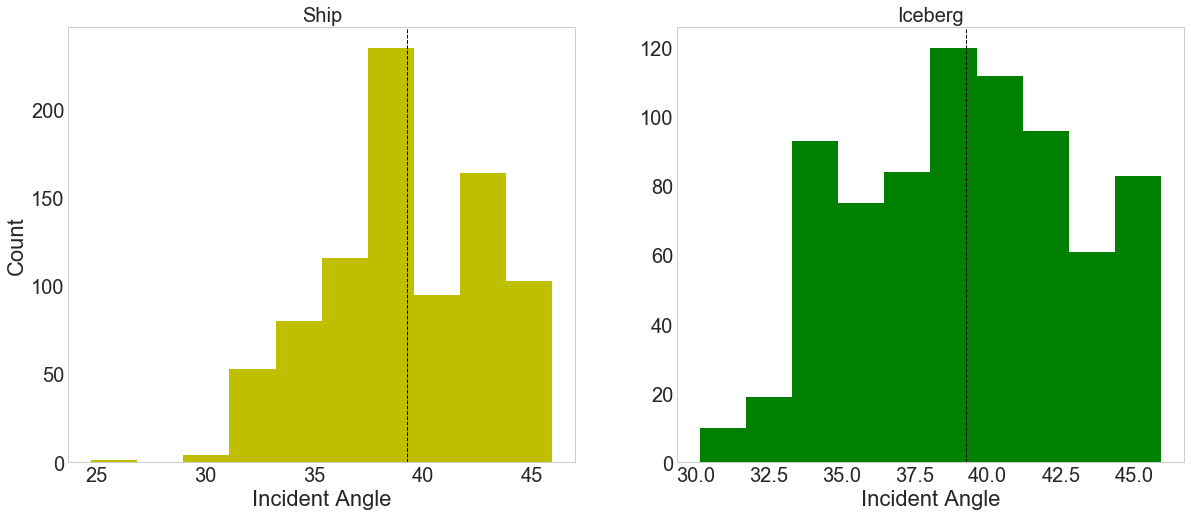

In [29]:
angle_count  = train.inc_angle.value_counts()
plt.figure(figsize=(8,8))
f,(ax1,ax2)=plt.subplots(1,2,figsize=(20,8))

len(train_df[train_df.is_iceberg==0])
ax1.axvline(np.asarray(train_df[train_df.is_iceberg==0].inc_angle).mean(), color='k', linestyle='dashed', linewidth=1)
ax1.hist(np.asarray(train_df[train_df.is_iceberg==0].inc_angle), color='y', label='Iceberg')
ax2.axvline(np.asarray(train_df[train_df.is_iceberg==1].inc_angle).mean(), color='k', linestyle='dashed', linewidth=1)
ax2.hist(np.asarray(train_df[train_df.is_iceberg==1].inc_angle),color='g', label='Ship')
ax1.set_title('Ship')
ax2.set_title('Iceberg')
ax1.set_xlabel('Incident Angle')
ax2.set_xlabel('Incident Angle')
ax1.set_ylabel('Count')
plt.show()

([<matplotlib.axis.XTick at 0x1bd1b2aeef0>,
 <a list of 4 Text xticklabel objects>)

([<matplotlib.axis.YTick at 0x1bd1c5f4080>,
 <a list of 4 Text yticklabel objects>)

Text(0.5,1,'Correlation Matrix of Global Variables')

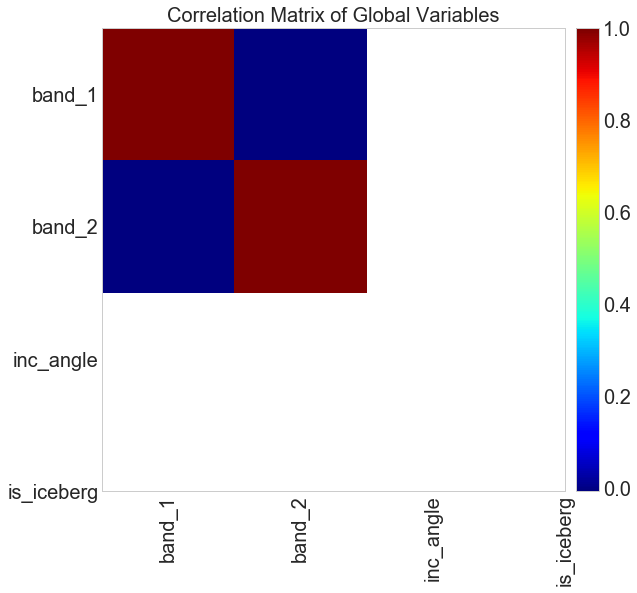

In [32]:
train_stats = train_df.drop(['id'],axis=1)
corr = train_stats.corr()
fig = plt.figure(1, figsize=(10,10))
plt.imshow(corr,cmap='jet')
labels = np.arange(len(train_stats.columns))
plt.xticks(labels,train_stats.columns,rotation=90)
plt.yticks(labels,train_stats.columns)
plt.title('Correlation Matrix of Global Variables')
cbar = plt.colorbar(shrink=0.85,pad=0.02)
plt.show()

ValueError: c of shape (4,) not acceptable as a color sequence for x with size 1604, y with size 1604

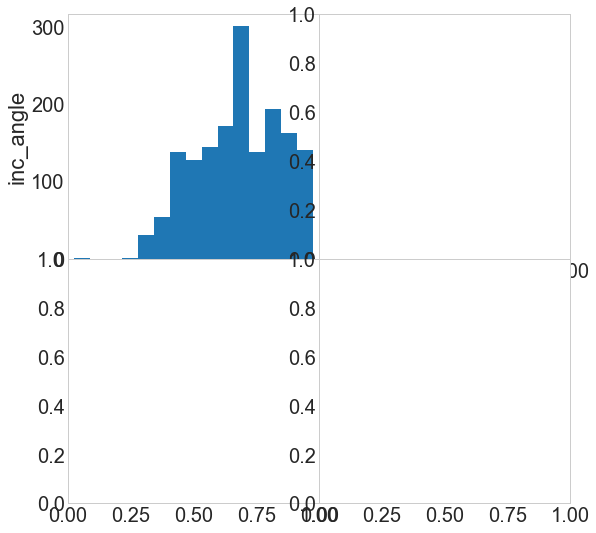

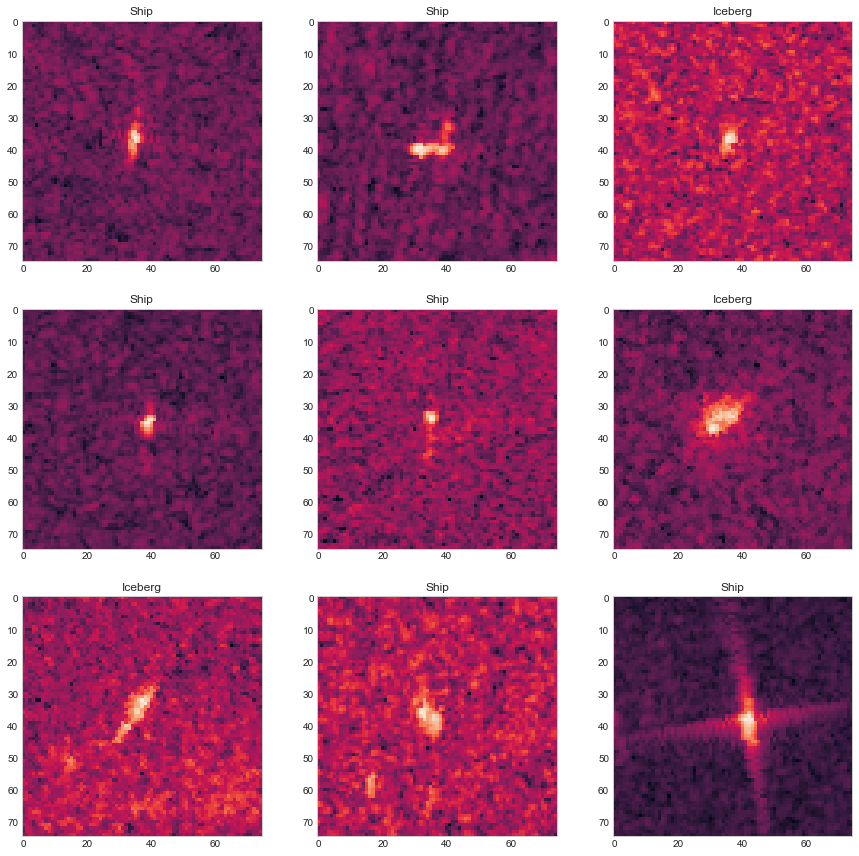

In [154]:
#xder = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
#yder = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])

fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    band_1_ex = train_df.loc[i,'band_1']
    band_1_ex = np.array(band_1_ex)
    band_1_square = band_1_ex.reshape(75, 75)
    plt.imshow(band_1_square)
    titles = ['Ship','Iceberg']
    plt.title(titles[train_df.is_iceberg[i]])
plt.show()

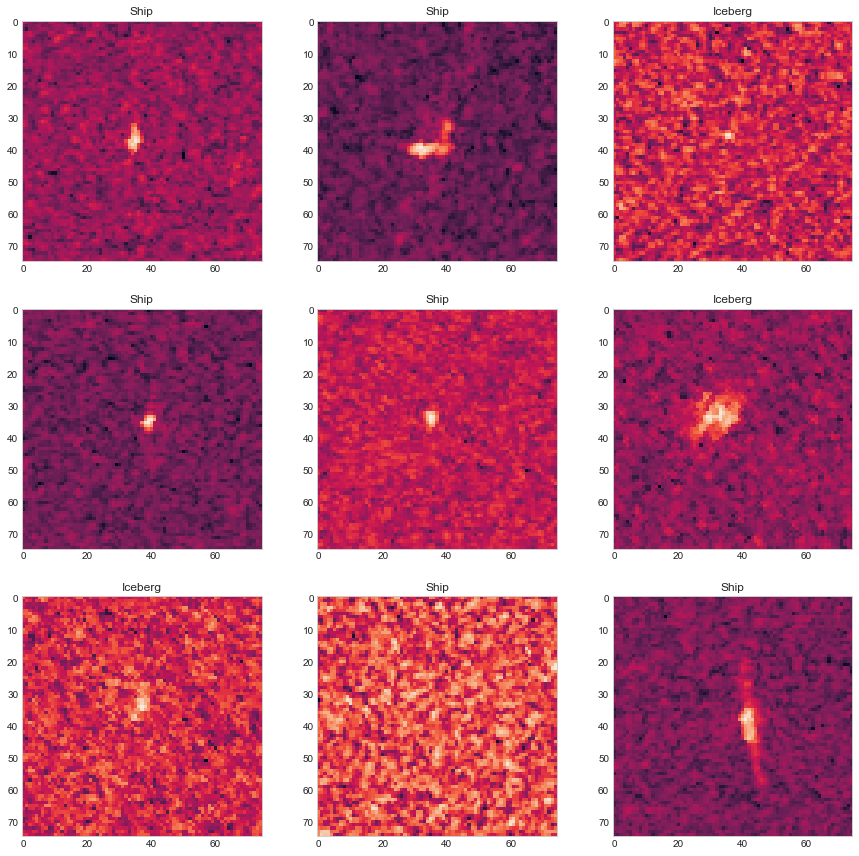

In [159]:
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    band_1_ex = train_df.loc[i,'band_2']
    band_1_ex = np.array(band_1_ex)
    band_1_square = band_1_ex.reshape(75, 75)
    plt.imshow(band_1_square)
    titles = ['Ship','Iceberg']
    plt.title(titles[train_df.is_iceberg[i]])
plt.show()

In [146]:
band_1_ex = train_df.loc[i, 'band_1']
band_1_ex
train_df.sample(16)
for i,img in enumerate(traindf):
    print(img)
    i
    

band_1
band_2
id
inc_angle
is_iceberg


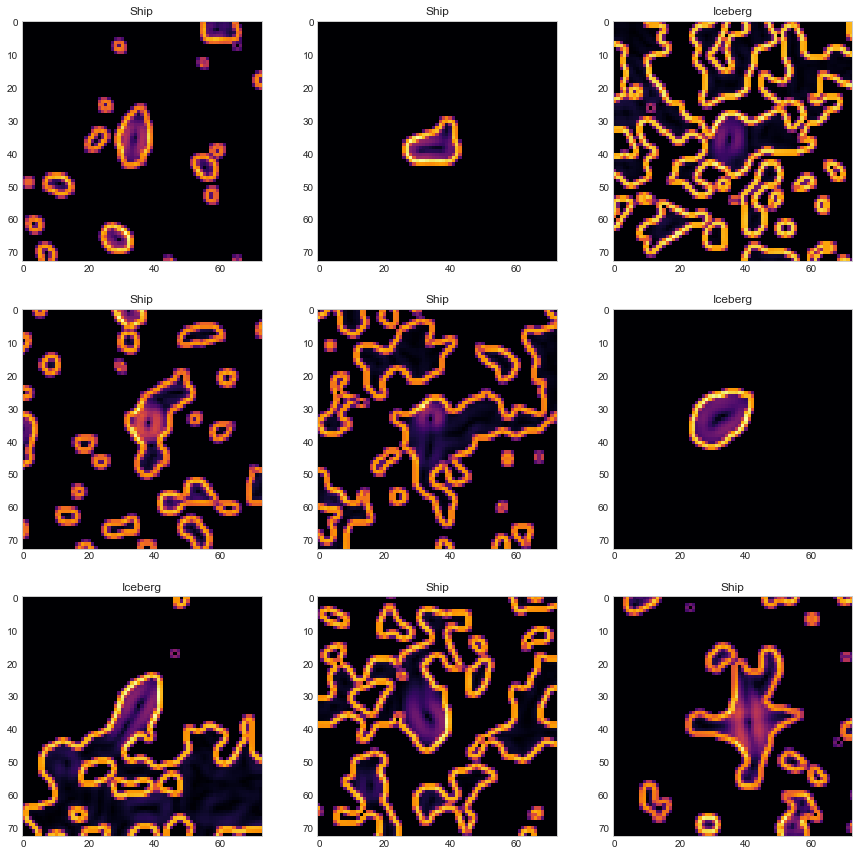

In [212]:

import cv2
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    band_1_ex = train_df.loc[i, 'band_1']
    band_1_ex = np.array(band_1_ex)
    band_1_square = band_1_ex.reshape(75, 75)
    tt= np.uint8((255. - 0) / (band_1_square.max() - band_1_square.min()) * (band_1_square - band_1_square.min()) + band_1_square.min())
    blur = cv2.GaussianBlur(tt, (75, 75), 2)
#blur = cv2.GaussianBlur(img,(5,5),0)
    _,th3 = cv2.threshold(blur,0,255,cv2.THRESH_TOZERO+cv2.THRESH_OTSU)
    arrx = signal.convolve2d(th3,xder,mode='valid')
    arry = signal.convolve2d(th3,yder,mode='valid')
    
    titles = ['Ship','Iceberg']
    plt.imshow(th3,cmap='jet')
    plt.title(titles[train_df.is_iceberg[i]])
    ax.imshow(np.hypot(arrx,arry),cmap='inferno')
        
plt.show()


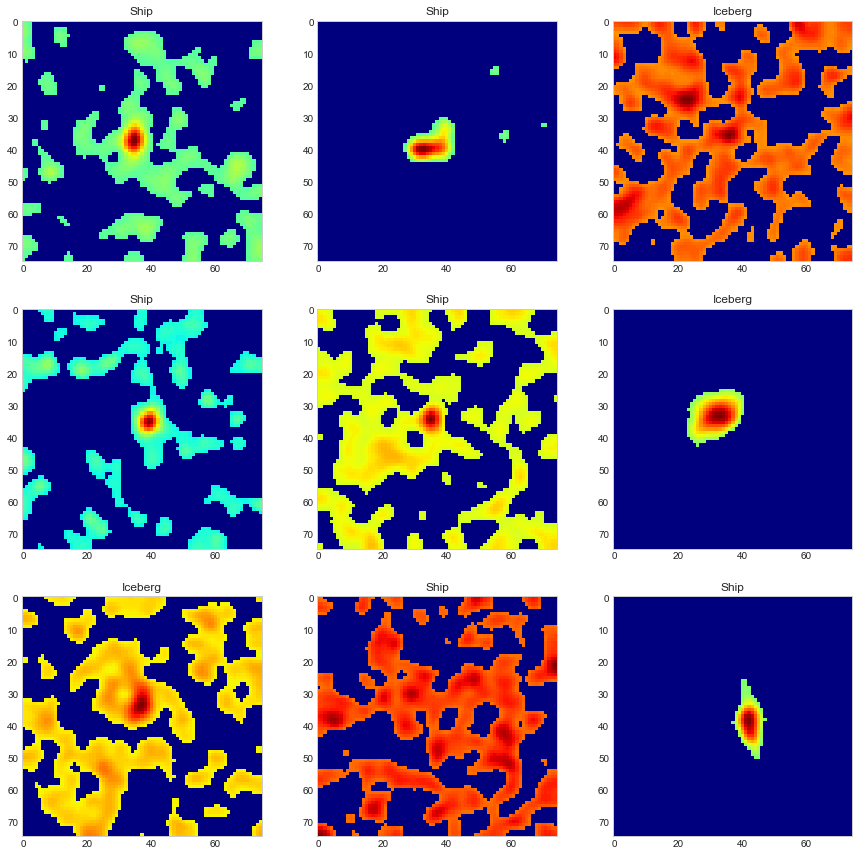

In [207]:
import cv2
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    band_1_ex = train_df.loc[i, 'band_2']
    band_1_ex = np.array(band_1_ex)
    band_1_square = band_1_ex.reshape(75, 75)
    tt= np.uint8((255. - 0) / (band_1_square.max() - band_1_square.min()) * (band_1_square - band_1_square.min()) + band_1_square.min())
    blur = cv2.GaussianBlur(tt, (75, 75), 2)
#blur = cv2.GaussianBlur(img,(5,5),0)
    _,th3 = cv2.threshold(blur,0,255,cv2.THRESH_TOZERO+cv2.THRESH_OTSU)
    
    titles = ['Ship','Iceberg']
    plt.imshow(th3,cmap='jet')
    plt.title(titles[train_df.is_iceberg[i]])
        
plt.show()

In [ ]:
## Observations
## 1. Band-2 images seem to have more noise than Band-1 images on an average
## 2. Iceberg images seem to have more intensity deviation than the ship ones on an average
## (like an iceberg may have small parts floating around while the ship is a single-blob)

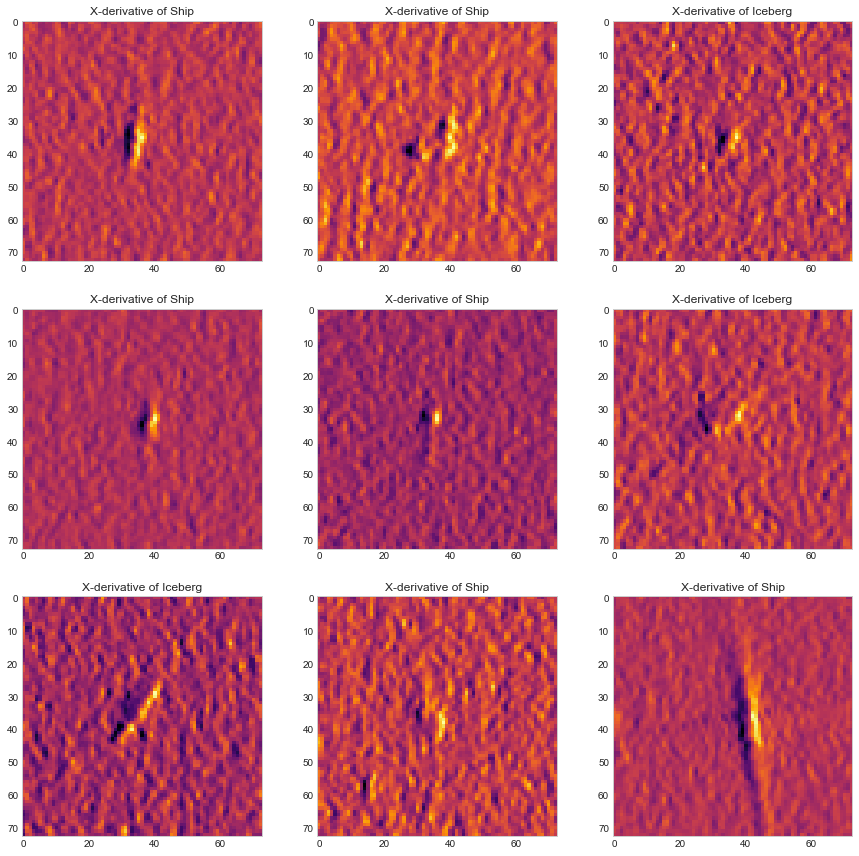

In [208]:
# An X-derivative will typically be antisymmetric with respect to reversing the values around the x-axis. 
# This will provide some level of edge detection in the x-direction. 

from scipy import signal
xder = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
yder = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = signal.convolve2d(np.reshape(np.array(train_df.loc[i, 'band_1']),(75,75)),xder,mode='valid')
    ax.imshow(arr,cmap='inferno')
    titles = ['Ship','Iceberg']
    ax.set_title('X-derivative of %s' % titles[train_df.is_iceberg[i]])
    
plt.show()

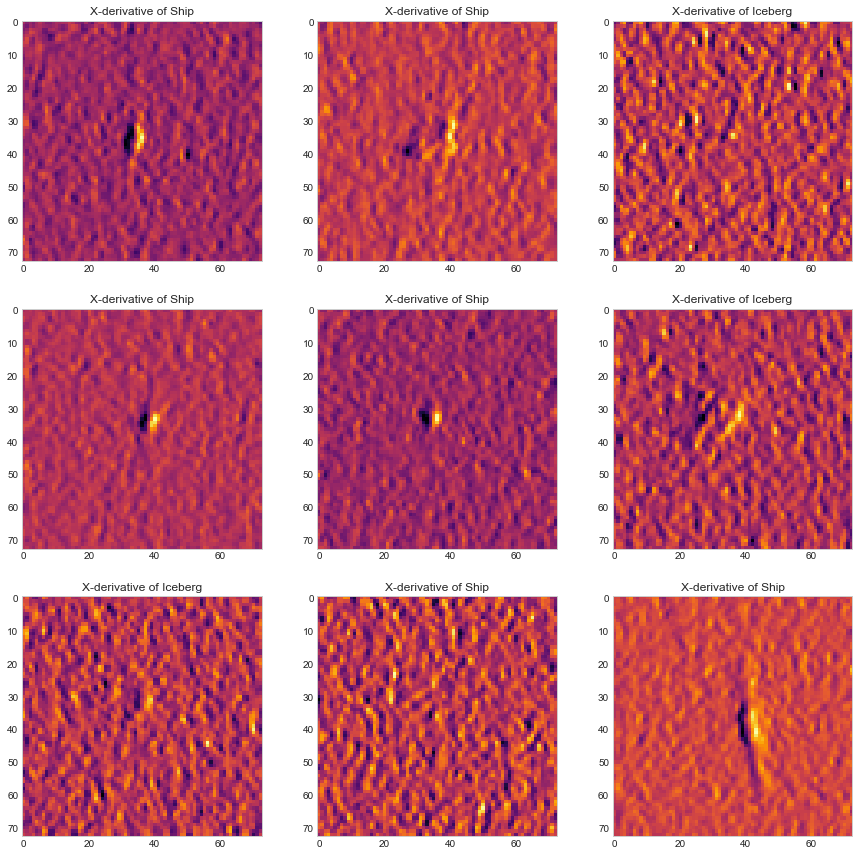

In [164]:
from scipy import signal
xder = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
yder = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = signal.convolve2d(np.reshape(np.array(train_df.loc[i, 'band_2']),(75,75)),xder,mode='valid')
    ax.imshow(arr,cmap='inferno')
    titles = ['Ship','Iceberg']
    ax.set_title('X-derivative of %s' % titles[train_df.is_iceberg[i]])
    
plt.show()

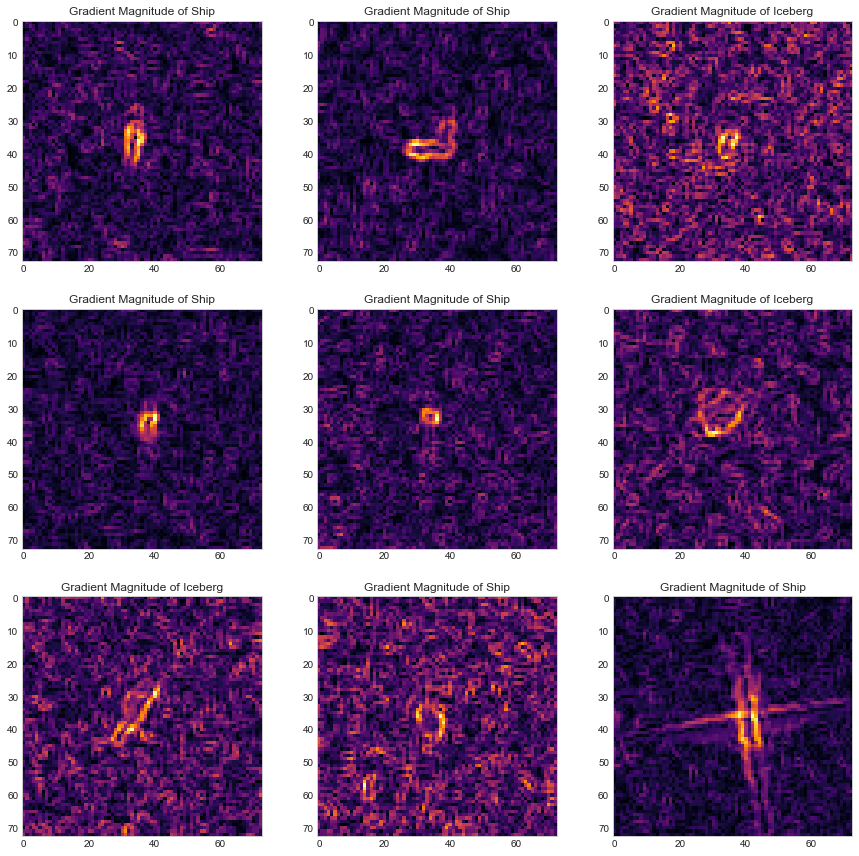

In [166]:
# treating the x and y derivatives as a gradient vector at each position and then taking the magnitude at each point.

fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arrx = signal.convolve2d(np.reshape(np.array(train_df.loc[i, 'band_1']),(75,75)),xder,mode='valid')
    arry = signal.convolve2d(np.reshape(np.array(train_df.loc[i, 'band_1']),(75,75)),yder,mode='valid')
    ax.imshow(np.hypot(arrx,arry),cmap='inferno')
    titles = ['Ship','Iceberg']
    ax.set_title('Gradient Magnitude of %s' % titles[train_df.is_iceberg[i]])
plt.show()

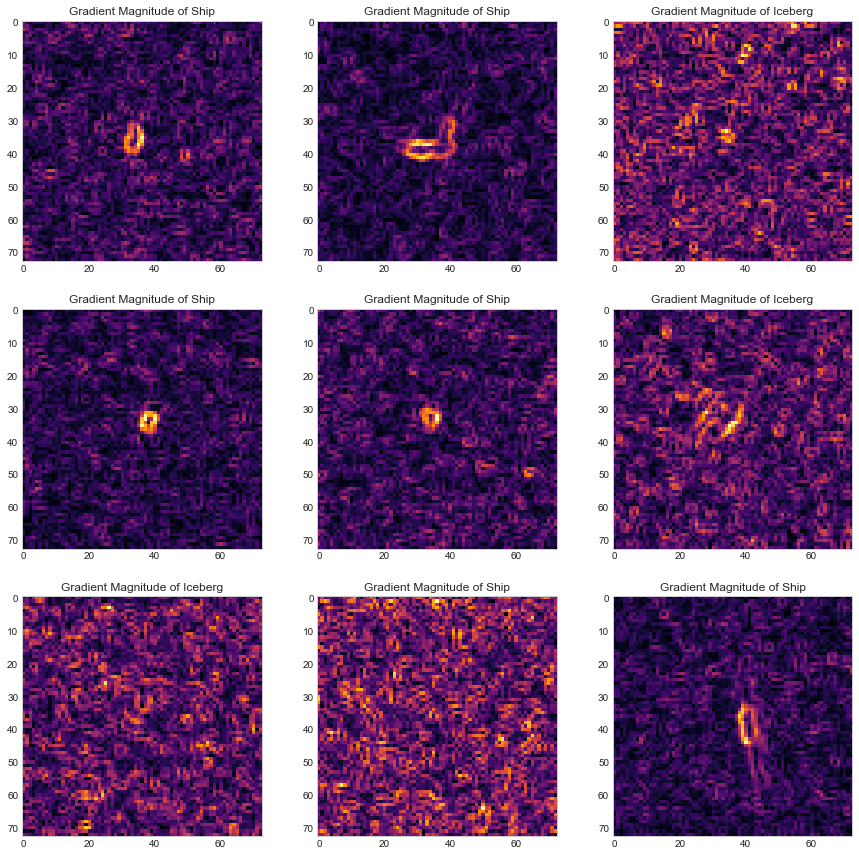

In [165]:
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arrx = signal.convolve2d(np.reshape(np.array(train_df.loc[i, 'band_2']),(75,75)),xder,mode='valid')
    arry = signal.convolve2d(np.reshape(np.array(train_df.loc[i, 'band_2']),(75,75)),yder,mode='valid')
    ax.imshow(np.hypot(arrx,arry),cmap='inferno')
    titles = ['Ship','Iceberg']
    ax.set_title('Gradient Magnitude of %s' % titles[train_df.is_iceberg[i]])
plt.show()

#We see interesting circular shapes everywhere in these images and the signals look fairly strong. 
#The ships, in particular, show fairly bright edges and most create nice loops. 
#This operation might be useful to put into a more advanced model like a neural net.
# It would be good to compare the results with the original images

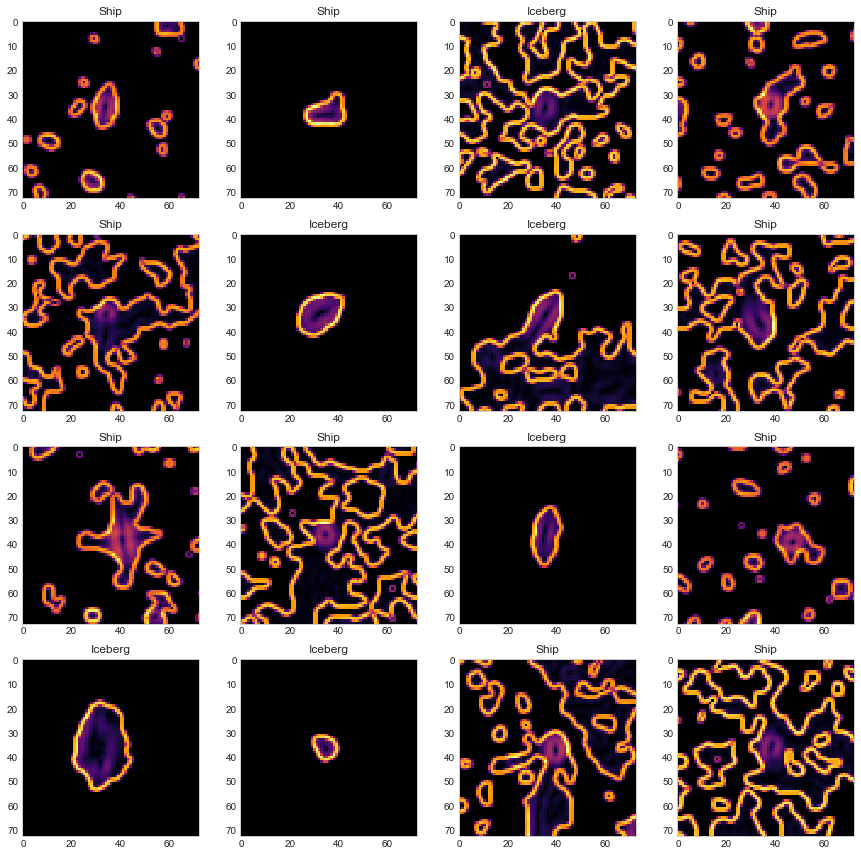

In [214]:
import cv2
fig = plt.figure(1,figsize=(15,15))
for i in range(16):
    ax = fig.add_subplot(4,4,i+1)
    band_1_ex = train_df.loc[i, 'band_1']
    band_1_ex = np.array(band_1_ex)
    band_1_square = band_1_ex.reshape(75, 75)
    tt= np.uint8((255. - 0) / (band_1_square.max() - band_1_square.min()) * (band_1_square - band_1_square.min()) + band_1_square.min())
    blur = cv2.GaussianBlur(tt, (75, 75), 2)
#blur = cv2.GaussianBlur(img,(5,5),0)
    _,th3 = cv2.threshold(blur,0,255,cv2.THRESH_TOZERO+cv2.THRESH_OTSU)
    arrx = signal.convolve2d(th3,xder,mode='valid')
    arry = signal.convolve2d(th3,yder,mode='valid')
    titles = ['Ship','Iceberg']
    ax.imshow(np.hypot(arrx,arry),cmap='inferno')
    plt.title(titles[train_df.is_iceberg[i]])
        
plt.show()

In [215]:
xder
yder

array([[ 1,  2,  1],
       [ 0,  0,  0],
       [-1, -2, -1]])

In [9]:
import os
os.sys.path

['',
 'C:\\Users\\akash\\Anaconda3\\python36.zip',
 'C:\\Users\\akash\\Anaconda3\\DLLs',
 'C:\\Users\\akash\\Anaconda3\\lib',
 'C:\\Users\\akash\\Anaconda3',
 'C:\\Users\\akash\\Anaconda3\\lib\\site-packages',
 'C:\\Users\\akash\\Anaconda3\\lib\\site-packages\\win32',
 'C:\\Users\\akash\\Anaconda3\\lib\\site-packages\\win32\\lib',
 'C:\\Users\\akash\\Anaconda3\\lib\\site-packages\\Pythonwin',
 'C:\\Users\\akash\\Anaconda3\\lib\\site-packages\\IPython\\extensions',
 'C:\\Users\\akash\\.ipython']

In [ ]:
img = cv2.imread('image.jpg')
blur = cv2.GaussianBlur(img, (15, 15), 2)
hsv = cv2.cvtColor(blur, cv2.COLOR_BGR2HSV)
lower_green = np.array([37, 0, 0])
upper_green = np.array([179, 255, 255])
mask = cv2.inRange(hsv, lower_green, upper_green)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
opened_mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
masked_img = cv2.bitwise_and(img, img, mask=opened_mask)
cv2.imshow('', masked_img)
cv2.waitKey()

In [2]:
pwd


try t n p test

make data file path as relative


'C:\\Users\\akash\\Documents\\Madhuri stuff\\FULL-TENSORFLOW-NOTES-AND-DATA\\Tensorflow-Bootcamp-master'